In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sys
import math
sys.path.append('/home/eduardo/PycharmProjects/treemap-analysis/code')

import Parser
import SpatialMetrics
import TemporalMetrics

In [3]:
dataset_id = 'exports'

In [4]:
def styleBoxplot(bp, ax, n_revisions):
    
    def get_ax_size(ax):
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        width, height = bbox.width, bbox.height
        width *= fig.dpi
        height *= fig.dpi
        return width, height
    
    for box in bp['boxes']:
        # change outline color
        box.set(color='#1b9e77', linewidth=0)
        # change fill color
        box.set(facecolor='#1b9e77')
        box.set_zorder(10)
    for i, median in enumerate(bp['medians']):
        median.set(color='#1445FF', linewidth=2, ms=(get_ax_size(ax)[0])/(n_revisions))
        median.set_zorder(11)
        median.set_xdata([i + 1 - 0.3, i + 1 + 0.3])
    for whisker in bp['whiskers']:
        whisker.set(color='#CCCCCC', linestyle='-', linewidth=(get_ax_size(ax)[0])/(n_revisions))
    for cap in bp['caps']:
        cap.set(color='#FFFFFF', linewidth=0)
        
    # ax.set_ylim([0, 1])
    
    # Set only 3 ticks on x
    ax.set_xticks([1, n_revisions / 2, n_revisions], minor=False)
    ax.set_xticklabels([1, int(n_revisions / 2), n_revisions], fontdict=None, minor=False)
    
    # Remove extra spines and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_zorder(20)
    ax.spines['bottom'].set_zorder(20)
    ax.tick_params(axis='x', which='both', top='off', direction='out')
    ax.tick_params(axis='y', which='both', right='off', direction='out')

def cm2inch(value):
    return value/2.54

# Aggregated spatial metric boxplots
How to Aggregate Q_ar and Q_weighted_ar in barplot statistics? 5%, 25%, 50% (median), 75%, 95%.

Just averaging items doesn't work. See below.

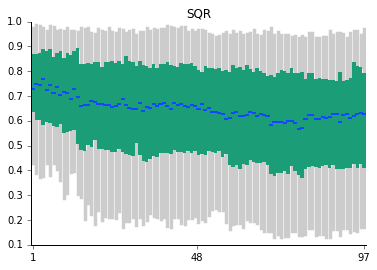

In [6]:
fig = plt.figure()
ax = plt.gca()
ax.set_title('sqr'.upper())

M = 2  # Number of metrics

# 5%, first quartile, median, third quartile, 95% statistics lists
statistics_list = []

history = Parser.parse_rectangles('sqr', dataset_id)
for i, df in enumerate(history):
    N = len(df)
    
    df_ar = SpatialMetrics.q_ar(df)
    df_ar = df_ar.assign(weight = pd.Series(1 /(N * M), index=df.index))
    #print(df_ar)
    
    
    df_w_ar = SpatialMetrics.q_ar(df)
    df_w_ar = pd.merge(df_w_ar, SpatialMetrics.weight(df), left_index=True, right_index=True)
    df_w_ar = df_ar.assign(weight = pd.Series(df_w_ar['weight'] / M, index=df.index))
    #print(df_w_ar)
    
    df_rev = pd.concat([df_ar, df_w_ar]) 
    #print(df_rev['weight'].sum())  # Sum is 1    
    
    df_rev = df_rev.sort_values(by='q_ar')
    df_rev['weight'] = df_rev['weight'].cumsum()
    # print(df_rev)
    
    # 5%, first quartile, median, third quartile, 95%
    f = fq = median = tq = nf = float("nan") 
    for i, row in df_rev.iterrows():
        if row['weight'] >= 0.05 and math.isnan(f):
            f = row['q_ar']
        if row['weight'] >= 0.25 and math.isnan(fq):
            fq = row['q_ar']
        if row['weight'] >= 0.5 and math.isnan(median):
            median = row['q_ar']
        if row['weight'] >= 0.75 and math.isnan(tq):
            tq = row['q_ar']
        if row['weight'] >= 0.95 and math.isnan(nf):
            nf = row['q_ar']
            
    item = {}
    item["med"] = median
    item["q1"] = fq
    item["q3"] = tq
    item["whislo"] = f
    item["whishi"] = nf
    item["fliers"] = []
    statistics_list.append(item)
    
    
bp = ax.bxp(statistics_list, patch_artist=True, widths=1);
styleBoxplot(bp, ax, len(history))

In [6]:
# technique_list = Parser.list_techniques()
# nrow = 7
# ncol = 2
# fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(cm2inch(20), cm2inch(2*22)))
# fig.delaxes(axs[6, 1])
# fig.tight_layout()

# for i, ax in enumerate(fig.axes):
#     ax.set_title(technique_list[i].upper())
    
#     data = []
#     history = Parser.parse_rectangles(technique_list[i], dataset_id)
#     for i, df in enumerate(history):
#         df_ar = SpatialMetrics.q_ar(df)
#         df_ar = pd.merge(df_ar, SpatialMetrics.q_weighted_ar(df), left_index=True, right_index=True)
        
#     bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);
#     styleBoxplot(bp, ax, len(data))

#     ax.set_ylim([0, 1])
#     ax.set_yticks([0, .25, .5, .75, 1], minor=False)
#     ax.set_yticklabels([0, .25, .5, .75, 1], fontdict=None, minor=False)
 
# #fig.savefig('time/svg/' + dataset_id + '_spatial.svg', format='svg', dpi=1200)

# Aggregated stability metrics boxplots
Weighted and unweighted ratio metrics using the corner travel dist as delta_vis

In [7]:
# technique_list = Parser.list_techniques()
# nrow = 7
# ncol = 2
# fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(cm2inch(20), cm2inch(2*22)))
# fig.delaxes(axs[6, 1])
# fig.tight_layout()
# for i, ax in enumerate(fig.axes):
#     ax.set_title(technique_list[i].upper())

#     data = []
#     history = Parser.parse_rectangles(technique_list[i], dataset_id)
#     for i in range(1, len(history)):
#         df = TemporalMetrics.delta_vis(history[i - 1], history[i])
#         df = pd.merge(df, TemporalMetrics.delta_data_by_area(history[i - 1], history[i]), left_index=True, right_index=True)
#         df = pd.merge(df, TemporalMetrics.relative_weight(history[i - 1], history[i]), left_index=True, right_index=True)

#         df_stab = TemporalMetrics.q_ratio(df)
#         df_stab = pd.merge(df_stab, TemporalMetrics.q_weighted_ratio(df), left_index=True, right_index=True)
        
#         column = 't' + str(i)
#         data.append(df_stab.mean(axis=1))

#     bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);
    
#     ax.set_ylim(ymin=-0.05)
#     ax.set_yticks([0, .25, .5, .75], minor=False)
#     ax.set_yticklabels([0, .25, .5, .75], fontdict=None, minor=False)
#     styleBoxplot(bp, ax, len(data))

# # fig.savefig('time/svg/' + dataset_id + '_stab.svg', format='svg', dpi=1200)

In [1]:
fig = plt.figure()
ax = plt.gca()
ax.set_title('sqr'.upper())

data = []
history = Parser.parse_rectangles('sqr', dataset_id)
for i in range(1, len(history)):
    df = TemporalMetrics.delta_vis(history[i - 1], history[i])
    df = pd.merge(df, TemporalMetrics.delta_data_by_area(history[i - 1], history[i]), left_index=True, right_index=True)
    df = pd.merge(df, TemporalMetrics.relative_weight(history[i - 1], history[i]), left_index=True, right_index=True)

    df_stab = TemporalMetrics.q_ratio(df)
    #df_stab = pd.merge(df_stab, TemporalMetrics.q_weighted_ratio(df), left_index=True, right_index=True)
    data.append(df_stab)
    
    
bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);
styleBoxplot(bp, ax, len(history))

NameError: name 'plt' is not defined

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


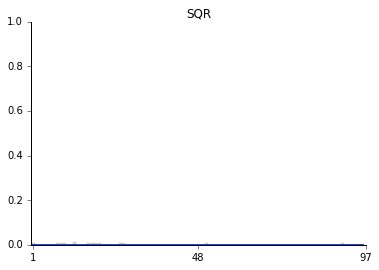

In [9]:
fig = plt.figure()
ax = plt.gca()
ax.set_title('sqr'.upper())

data = []
history = Parser.parse_rectangles('sqr', dataset_id)
for i in range(1, len(history)):
    df = TemporalMetrics.relative_position_change_wrapper(history[i - 1], history[i])
    df = pd.merge(df, TemporalMetrics.delta_data_by_area(history[i - 1], history[i]), left_index=True, right_index=True)
    df = pd.merge(df, TemporalMetrics.relative_weight(history[i - 1], history[i]), left_index=True, right_index=True)
    
    print(i)
    
    df_stab = TemporalMetrics.q_ratio(df)
    #df_stab = pd.merge(df_stab, TemporalMetrics.q_weighted_ratio(df), left_index=True, right_index=True)
    data.append(df_stab)
    
    
bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);
styleBoxplot(bp, ax, len(history))

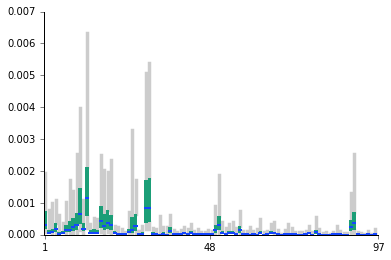

In [12]:
fig = plt.figure()
ax = plt.gca()
bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);
styleBoxplot(bp, ax, len(history))